In [68]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

np.set_printoptions(threshold=np.inf)  # Убирает ограничение на вывод


In [69]:
def factorize_polynomial(coeffs):
    a_n = coeffs[0]

    roots = np.roots(coeffs)

    def format_root(r):
        real_part = f"{r.real:.4g}".rstrip('0').rstrip('.')  # Убираем лишние нули в вещественной части
        imag_part = f"{r.imag:.4g}".rstrip('0').rstrip('.')  # Убираем лишние нули в мнимой части

        if r.imag == 0:
            return f"{real_part}"
        elif r.real == 0:
            return f"{imag_part}j"
        else:
            return f"({real_part} {'+' if r.imag > 0 else '-'} {abs(float(imag_part))}j)"

    factorized_str = f"{a_n:.4g} * " + " * ".join([f"(p - {format_root(r)})" for r in roots])

    return factorized_str, roots


def count_right_left_roots(roots):
    left_count = sum(1 for r in roots if np.real(r) < 0)   # Левые корни
    right_count = sum(1 for r in roots if np.real(r) > 0)  # Правые корни

    return left_count, right_count

In [70]:
def hurwitz_criterion(coefs):
    n = len(coefs) - 1  # степень полинома
    details = "\nРезультат анализа по критерию Гурвица:\n"

    # Необходимое условие: все коэффициенты должны быть положительными.
    if any(c <= 0 for c in coefs):
        details += "Не все коэффициенты положительны. Система неустойчива.\n"
        return False, details

    b = sorted(coefs, key=lambda x: -abs(x))  # Сортировка по убыванию

    # Инициализируем матрицу
    H = np.zeros((n, n))

    # Заполняем матрицу
    for i in range(n):
        for j in range(n):
            idx = 2 * j - i + 1
            if 0 <= idx < len(b):
                H[i, j] = b[idx]
            else:
                H[i, j] = 0

    details += "Матрица Гурвица\n" + str(H) + "\n\n"

    # Вычисляем ведущие определители (главные миноры)
    details += "Мажорные определители\n"
    determinants = []
    for i in range(1, n + 1):
        submatrix = H[:i, :i]
        det = np.linalg.det(submatrix)
        determinants.append(det)
        details += f"Δ{i} = {det:.4f}\n"

    # Если все определители положительны, система устойчива
    is_stable = all(det > 0 for det in determinants)
    if is_stable:
        details += "Все ведущие определители положительны. Система устойчива.\n"
    else:
        details += "Найден отрицательный определитель. Система неустойчива.\n"

    return is_stable, details

In [71]:
p, k, T1, T2, eps = sp.symbols('p k T1 T2 eps')

# Передаточная функция W(p)
W_p = (k * p) / ((T1 * p + 1) * (T2**2 * p**2 + 2 * T2 * eps * p + 1))

# Вычисляем знаменатель
denominator = sp.expand((T1 * p + 1) * (T2**2 * p**2 + 2 * T2 * eps * p + 1))

# Извлекаем коэффициенты
coeffs_symbolic = sp.Poly(denominator, p).all_coeffs()

# Подставляем
# params = {k: 6, T1: 1.2, T2: 0.08, eps: 0.06} # anya
params = {k: 0.5, T1: 6, T2: 4, eps: 0.6}
coeffs_numeric = [float(coeff.subs(params)) for coeff in coeffs_symbolic]

# Вывод коэффициентов
print("Символьные коэффициенты:")
for i, coeff in enumerate(coeffs_symbolic[::-1]):
    print(f"a{i} =", coeff)

print("\nЧисловые коэффициенты:")
for coef in coeffs_numeric:
    print(coef,end="  ")

Символьные коэффициенты:
a0 = 1
a1 = T1 + 2*T2*eps
a2 = 2*T1*T2*eps + T2**2
a3 = T1*T2**2

Числовые коэффициенты:
96.0  44.8  10.8  1.0  

In [72]:
# критерий Гурвица - коэффициенты и определители положительны
hurw_stable, hurw_details = hurwitz_criterion(coeffs_numeric)
print(hurw_details)


Результат анализа по критерию Гурвица:
Матрица Гурвица
[[44.8  1.   0. ]
 [96.  10.8  0. ]
 [ 0.  44.8  1. ]]

Мажорные определители
Δ1 = 44.8000
Δ2 = 387.8400
Δ3 = 387.8400
Все ведущие определители положительны. Система устойчива.



Михайлова

In [73]:
def Michailow_alternating(coeffs_numeric):
    w = sp.symbols('w', real=True)
    j = sp.I # Условное обозначение мнимой единицы

    p = j * w # Подставляем p = jw
    polynomial = sum(c * (p ** i) for i, c in enumerate(reversed(coeffs_numeric)))

    X = sp.re(polynomial)
    Y = sp.im(polynomial)

    print("Реальная часть (X):", X)
    print("Мнимая часть (Y):", Y)
    print()

    roots_X = sp.solveset(X, w)
    roots_Y = sp.solveset(Y, w)

    print("Корни X(w):", roots_X)
    print("Корни Y(w):", roots_Y)

    def filter_positive_roots(roots):
        return [root for root in roots if root.is_real and root >= 0]

    def check_alternation(roots_X, roots_Y):
        # Объединяем корни в один список
        all_roots = [(root, 'X') for root in roots_X] + [(root, 'Y') for root in roots_Y]
        all_roots.sort(key=lambda x: x[0])# сортировка в порядке возрастания
        # Проверяем чередование
        for i in range(1, len(all_roots)):
            if all_roots[i][1] == all_roots[i-1][1]:
                return False
        return True

    positive_X = filter_positive_roots(roots_X)
    positive_Y = filter_positive_roots(roots_Y)

    alternating = check_alternation(positive_X, positive_Y)
    print()

    if alternating:
        print("Корни чередуются, система устойчива по критерию Михайлова")
    else:
        print("Корни не чередуются, система не устойчива по критерию Михайлова")

Michailow_alternating(coeffs_numeric)


Реальная часть (X): 1.0 - 44.8*w**2
Мнимая часть (Y): -96.0*w**3 + 10.8*w

Корни X(w): {-0.149403576166799, 0.149403576166799}
Корни Y(w): {-0.335410196624968, 0, 0.335410196624968}

Корни чередуются, система устойчива по критерию Михайлова


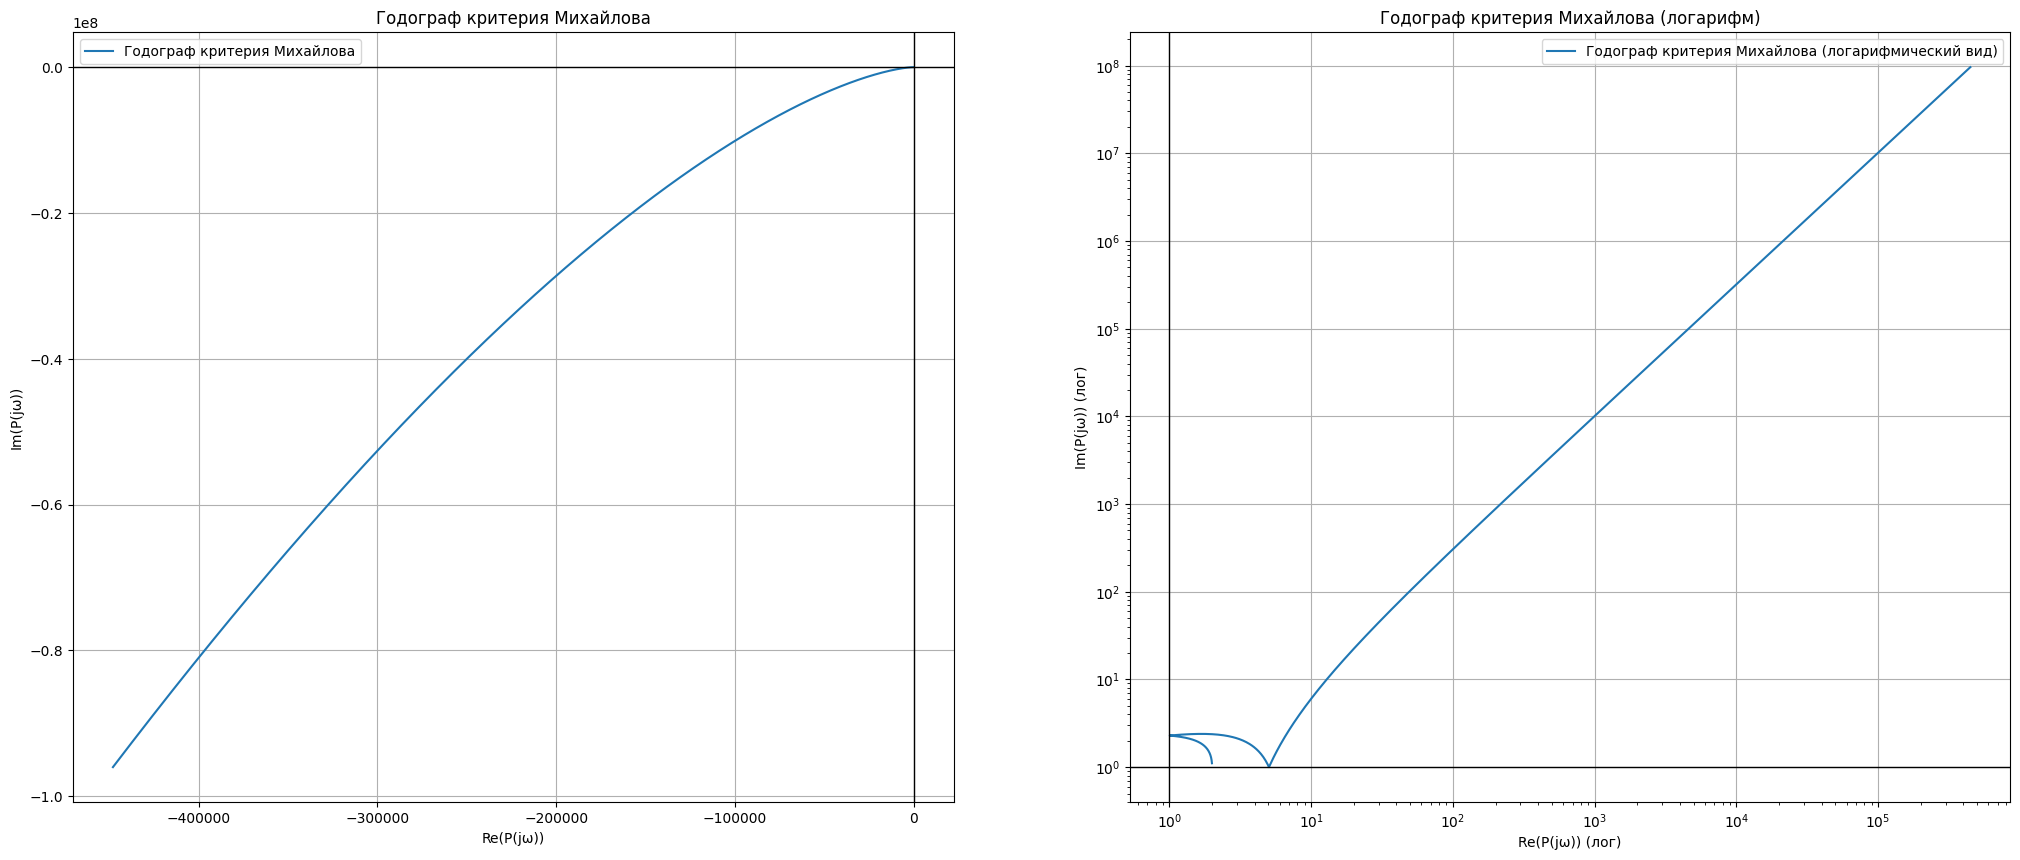

In [79]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def plot_mikhailov_hodograph(coeffs_numeric, w_min, w_max, num_points=1000):
    #Вычисляем корни и характерестическое уравнение в виде произведения множителей
    factorized_str,roots = factorize_polynomial(coeffs_numeric)
    left_roots, right_roots = count_right_left_roots(roots)

    # print("\nВыражение:")
    # print(factorized_str,end="\n\n")

    # print("left_roots  =",left_roots,end="\n")
    # print("right_roots =",right_roots,end="\n")

    if(right_roots != 0):
        print("Есть правые корни, система не устойчива")

    w = sp.symbols('w', real=True)
    j = sp.I  # Мнимая единица

    p = j * w
    polynomial = sum(c * (p ** i) for i, c in enumerate(reversed(coeffs_numeric)))

    X = sp.re(polynomial)
    Y = sp.im(polynomial)

    omega_values = np.linspace(w_min, w_max, num_points)
    omega_values_log = np.logspace(np.log10(w_min), np.log10(w_max), num_points)

    # Вычисляем значения X и Y
    X_values = [float(X.subs(w, omega)) for omega in omega_values]
    Y_values = [float(Y.subs(w, omega)) for omega in omega_values]

    X_values_log = [abs(float(X.subs(w, omega))) + 1 for omega in omega_values_log]
    Y_values_log = [abs(float(Y.subs(w, omega))) + 1 for omega in omega_values_log]
    # X_values_log = [np.log10(abs(float(X.subs(w, omega))))for omega in omega_values_log]
    # Y_values_log = [np.log10(abs(float(Y.subs(w, omega))))for omega in omega_values_log]

    # 1
    plt.figure(figsize=(25, 10))
    plt.subplot(1,2,1)

    plt.plot(X_values, Y_values, label="Годограф критерия Михайлова")
    plt.axhline(color='black', linestyle='-', linewidth=1)
    plt.axvline(color='black', linestyle='-', linewidth=1)

    plt.title("Годограф критерия Михайлова")
    plt.xlabel("Re(P(jω))")
    plt.ylabel("Im(P(jω))")
    plt.grid(True)
    plt.legend()

    # 2
    plt.subplot(1,2,2)
    plt.plot(X_values_log, Y_values_log, label="Годограф критерия Михайлова (логарифмический вид)")
    plt.xscale('log')
    plt.yscale('log')
    plt.axhline(1, color='black', linestyle='-', linewidth=1)
    plt.axvline(1, color='black', linestyle='-', linewidth=1)

    plt.title("Годограф критерия Михайлова (логарифм)")
    plt.xlabel("Re(P(jω)) (лог)")
    plt.ylabel("Im(P(jω)) (лог)")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_mikhailov_hodograph(coeffs_numeric, w_min=10**(-2), w_max=10**(2))
